In [1]:
import sklearn
import pandas
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score


import numpy as np

from sklearn.utils import resample

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

import pandas as pd

from gscore.osw.peakgroups import fetch_peak_groups
from gscore.osw.queries import (
    FETCH_UNSCORED_PEAK_GROUPS
)
from gscore.models.denoiser import DenoizingClassifier
from gscore.osw.connection import create_table

from gscore.models.preprocess import STANDARD_SCALAR_PIPELINE

%matplotlib inline

In [2]:
scored_files = [
    '/home/aaron/projects/gscorer/data/Simon_S1607_178.osw',
    #'/home/aaron/projects/gscorer/data/Simon_S1607_187.osw',
    #'/home/aaron/projects/gscorer/data/Simon_S1607_248.osw'
]

In [3]:
peak_groups = fetch_peak_groups(
    host=scored_files[0],
    query=FETCH_UNSCORED_PEAK_GROUPS
)

In [4]:
main_score_column = 'var_xcorr_shape'#fetch_main_score_col(swath_data)


In [5]:
swath_data = peak_groups.select_peak_group(
    return_all=True
)

In [6]:
highest_ranking_swath_data = swath_data.loc[
    swath_data.groupby(['transition_group_id'])[main_score_column].idxmax()
]

In [8]:
# highest_ranking_swath_data = highest_ranking_swath_data.drop(
#     highest_ranking_swath_data[
#         highest_ranking_swath_data.target == 0.0
#     ].index
# )


In [7]:
highest_ranking_swath_data.target.value_counts()

1.0    104228
0.0    103152
Name: target, dtype: int64

In [12]:
# lowest_ranking_swath_data = swath_data.loc[
#     swath_data.groupby(['transition_group_id'], as_index=False)[main_score_column].nth([1]).index
# ]

In [13]:
# lowest_ranking_swath_data = lowest_ranking_swath_data.drop(
#     lowest_ranking_swath_data[lowest_ranking_swath_data.target == 0.0].index
# )

# lowest_ranking_swath_data['target'] = 0.0
# lowest_ranking_swath_data['decoy'] = 1.0

In [14]:
# lowest_ranking_swath_data.target.value_counts()


0.0    104211
Name: target, dtype: int64

In [15]:
# highest_ranking_swath_data = pandas.concat([highest_ranking_swath_data, lowest_ranking_swath_data])

In [8]:
print('target', len(highest_ranking_swath_data[highest_ranking_swath_data['target']==1]),
      'decoy', len(highest_ranking_swath_data[highest_ranking_swath_data['decoy']==1]))

target 104228 decoy 103152


In [9]:
ml_features = [col for col in swath_data.columns if col.startswith('var')]

In [10]:
from sklearn.utils import resample

num_classifiers = range(250)

denoizing_folds = list()

shuffled_peak_groups = highest_ranking_swath_data.sample(frac=1)

split_data = np.array_split(shuffled_peak_groups, 10)

for idx, testing_data in enumerate(split_data):
    
    training_data = pandas.concat(
         [data for i, data in enumerate(split_data) if i != idx]
    )
    
    swath_training_prepared = training_data.copy()
    
    scaling_pipeline = Pipeline([
        ('power_transformer', StandardScaler()),
    ])

    full_pipeline = ColumnTransformer([
        ('num', scaling_pipeline, ml_features),
    ])
    
    swath_training_prepared[ml_features] = full_pipeline.fit_transform(swath_training_prepared[ml_features])

    n_samples = int(len(swath_training_prepared) * 0.05)
    
    print(f'Training for fold {idx=} training size={len(swath_training_prepared)} testing_size={len(testing_data)} {n_samples=} for bagging')
    
    classifiers = list()
    
    for bagged_classifier in num_classifiers:

        denoizing_classifier = SGDClassifier(
            alpha=1e-05,
            average=True,
            loss='hinge',
            max_iter=1000,
            penalty='l2',
            random_state=bagged_classifier,
            shuffle=True,
            tol=0.0001,
            learning_rate='adaptive',
            eta0=0.001,
            fit_intercept=True
        )

        sampled_training_data = resample(
            swath_training_prepared,
            replace=True,
            n_samples=n_samples,
            random_state=bagged_classifier
        )

        sgd_classifier = denoizing_classifier.fit(
            sampled_training_data[ml_features], 
            sampled_training_data['target']
        )
        
        classifiers.append(sgd_classifier)
    
    denoizing_folds.append(
        (testing_data, classifiers, full_pipeline)
    )    


Training for fold idx=0 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=1 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=2 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=3 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=4 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=5 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=6 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=7 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=8 training size=186642 testing_size=20738 n_samples=9332 for bagging
Training for fold idx=9 training size=186642 testing_size=20738 n_samples=9332 for bagging


In [11]:
data_for_scoring = list()

for testing_data, classifiers, transform_pipeline in denoizing_folds:
    
    classifier_columns = list()
     
    swath_subset = swath_data.loc[
        swath_data.transition_group_id.isin(testing_data.transition_group_id)
    ]
    
    testing_prepared = swath_subset.copy()
    
    testing_prepared[ml_features] = transform_pipeline.transform(testing_prepared[ml_features])
    print('scoring fold')

    for num_classifier, classifier in enumerate(classifiers):
        classifier_key = f"num_{num_classifier}"
        classifier_columns.append(classifier_key)
        testing_prepared[classifier_key] = classifier.predict(testing_prepared[ml_features])
    testing_prepared['target_vote_percentage'] = testing_prepared[classifier_columns].sum(axis=1) / len(classifier_columns)
    data_for_scoring.append(testing_prepared)
    

scoring fold
scoring fold
scoring fold
scoring fold
scoring fold
scoring fold
scoring fold
scoring fold
scoring fold
scoring fold


In [12]:
len(testing_prepared)

103565

In [13]:
data_for_scoring = pandas.concat(data_for_scoring)

In [52]:
data_for_scoring.target_vote_percentage.value_counts()

0.000    43467
0.004    27869
0.008    20761
0.012    16494
0.016    14153
         ...  
0.352     2916
0.436     2914
0.424     2900
0.372     2889
0.340     2861
Name: target_vote_percentage, Length: 251, dtype: int64

In [53]:
data_for_scoring.target.value_counts()

1.0    520489
0.0    514982
Name: target, dtype: int64

In [16]:
highest_ranking_rescore = data_for_scoring.loc[
    data_for_scoring.groupby(['transition_group_id'])[main_score_column].idxmax()
]

In [54]:
len(highest_ranking_rescore)

207380

In [55]:
noise_filter = 0.90

In [56]:
highest_ranking_rescore.target.value_counts()

1.0    104228
0.0    103152
Name: target, dtype: int64

In [25]:
false_targets = highest_ranking_rescore.loc[
    highest_ranking_rescore[
        (highest_ranking_rescore['target_vote_percentage'] < noise_filter)].index
].copy()



In [57]:
true_targets = highest_ranking_rescore[
    (highest_ranking_rescore['target_vote_percentage'] >= noise_filter) &
    (highest_ranking_rescore['target'] == 1.0)    
].copy()


In [58]:
decoys = highest_ranking_rescore[highest_ranking_rescore.target == 0.0].copy()

In [59]:
true_targets.target.value_counts()

1.0    21645
Name: target, dtype: int64

In [60]:
removed_noise = pandas.concat([true_targets, decoys])

In [62]:
removed_noise.target.value_counts()

0.0    103152
1.0     21645
Name: target, dtype: int64

In [63]:
swath_training_data, swath_testing_data = train_test_split(removed_noise, test_size=0.1, random_state=42)

In [64]:
targets = swath_training_data[swath_training_data['target'] == 1.0]
decoys = swath_training_data[swath_training_data['target'] == 0.0]

In [65]:
print(len(targets) / (len(targets) + len(decoys)))

0.17293909203415334


In [66]:
# decoys_downsampled = resample(
#     decoys,
#     replace=False,
#     n_samples=len(targets),
#     random_state=42
# )

# swath_training_data = pandas.concat([targets, decoys_downsampled])

In [67]:
# targets_upsampled = resample(
#     targets,
#     replace=True,
#     n_samples=len(decoys),
#     random_state=42
# )

# swath_training_data = pandas.concat([targets_upsampled, decoys])

In [68]:
swath_training_data.target.value_counts()

0.0    92893
1.0    19424
Name: target, dtype: int64

In [69]:
removed_noise.target.value_counts()

0.0    103152
1.0     21645
Name: target, dtype: int64

In [70]:
swath_training_numeric = swath_training_data[ml_features]
swath_training_info = swath_training_data.drop(ml_features, axis=1)

swath_testing_numeric = swath_testing_data[ml_features]
swath_testing_info = swath_testing_data.drop(ml_features, axis=1)


In [71]:
scaling_pipeline = Pipeline([
    #('power_transformer', PowerTransformer()),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', scaling_pipeline, ml_features),
])

In [72]:
swath_training_prepared = full_pipeline.fit_transform(swath_training_numeric)
swath_training_prepared = pandas.DataFrame(swath_training_prepared, columns=ml_features, index=swath_training_numeric.index)

In [73]:
swath_training_combined = swath_training_info.join(swath_training_prepared)

In [74]:
swath_test_prepared = full_pipeline.transform(swath_testing_numeric)
swath_test_prepared = pandas.DataFrame(swath_test_prepared, columns=ml_features, index=swath_testing_numeric.index)
swath_testing_combined = swath_testing_info.join(swath_test_prepared)
#swath_full_prepared = full_pipeline.transform(swath_data_numeric)
#swath_full_prepared = pandas.DataFrame(swath_full_prepared, columns=ml_features, index=swath_data_numeric.index)

In [75]:
optimized_classifier = SGDClassifier(alpha=1e-05,
                                     average=True,
                                     loss='log',
                                     max_iter=1000,
                                     penalty='l2',
                                     random_state=42,
                                     shuffle=True,
                                     tol=0.0001,
                                     learning_rate='adaptive',
                                     eta0=0.001,
                                     fit_intercept=True)


In [76]:
optimized_classifier.fit(swath_training_combined[ml_features], swath_training_combined['target'])

SGDClassifier(alpha=1e-05, average=True, eta0=0.001, learning_rate='adaptive',
              loss='log', random_state=42, tol=0.0001)

In [77]:
feature_importance = list()
for name, score in zip(ml_features, optimized_classifier.coef_[0]):
    feature_importance.append((name, score))
    
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)
feature_importance

[('var_library_sangle', 0.9356854649211815),
 ('var_dotprod_score', 0.8887009453404501),
 ('var_xcorr_shape', 0.7482833767515641),
 ('var_library_rootmeansquare', -0.6302507240666037),
 ('var_xcorr_coelution', -0.6234173919585871),
 ('var_library_rmsd', -0.5941676147463949),
 ('var_library_corr', 0.527204487619561),
 ('var_xcorr_shape_weighted', 0.4515041573166258),
 ('var_library_dotprod', 0.401222633148554),
 ('var_massdev_score', -0.37747759948608134),
 ('var_manhattan_score', -0.3606663381437444),
 ('var_xcorr_shape_combined', -0.32618785196971445),
 ('var_xcorr_coelution_contrast', 0.32122349479792),
 ('var_isotope_correlation_score', 0.25539778563299886),
 ('var_yseries_score', -0.2336644815695763),
 ('var_bseries_score', 0.18351644230198658),
 ('var_norm_rt_score', 0.11229580262102415),
 ('var_log_sn_score', 0.10971229647955583),
 ('var_massdev_score_weighted', -0.10827541437968208),
 ('var_xcorr_coelution_weighted', -0.09302377331041106),
 ('var_xcorr_shape_contrast', -0.046660

In [78]:
 print(cross_val_score(
             optimized_classifier, 
             swath_training_combined[ml_features], 
             swath_training_combined['target'], 
             cv=10, 
             scoring='accuracy')
         )

[0.83956553 0.83938746 0.83787393 0.84357194 0.84259259 0.84054487
 0.83823006 0.84266762 0.84427032 0.83883893]


In [88]:
swath_testing_combined['decision_function'] = optimized_classifier.decision_function(swath_testing_combined[ml_features])
swath_training_combined['decision_function'] = optimized_classifier.decision_function(swath_training_combined[ml_features])

In [80]:
bins = 500#int(1.0 / 0.01)

In [81]:
swath_data_numeric = removed_noise[ml_features]
swath_data_info = removed_noise.drop(ml_features, axis=1)

swath_full_prepared = full_pipeline.transform(swath_data_numeric)
swath_full_prepared = pandas.DataFrame(swath_full_prepared, columns=ml_features, index=swath_data_numeric.index)

swath_testing_combined = swath_testing_info.join(swath_test_prepared)

swath_full_combined = swath_data_info.join(swath_full_prepared)

swath_full_combined['decision_function'] = optimized_classifier.decision_function(swath_full_combined[ml_features])

In [82]:
swath_numeric = swath_data[ml_features]
swath_info = swath_data.drop(ml_features, axis=1)

swath_prepared = full_pipeline.transform(swath_numeric)
swath_prepared = pandas.DataFrame(swath_prepared, columns=ml_features, index=swath_numeric.index)

swath_combined = swath_info.join(swath_prepared)

swath_combined['decision_function'] = optimized_classifier.decision_function(swath_combined[ml_features])

In [83]:
swath_combined_rerank = swath_combined.loc[
    swath_combined.groupby(['transition_group_id'])['decision_function'].idxmax()
]

In [84]:
second_ranked_targets = swath_combined.loc[
    swath_combined.groupby(
        ['transition_group_id'], as_index=False
    )['decision_function'].nth([1]).index
]

<ipython-input-89-fc4a5c02a633>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  test.show()


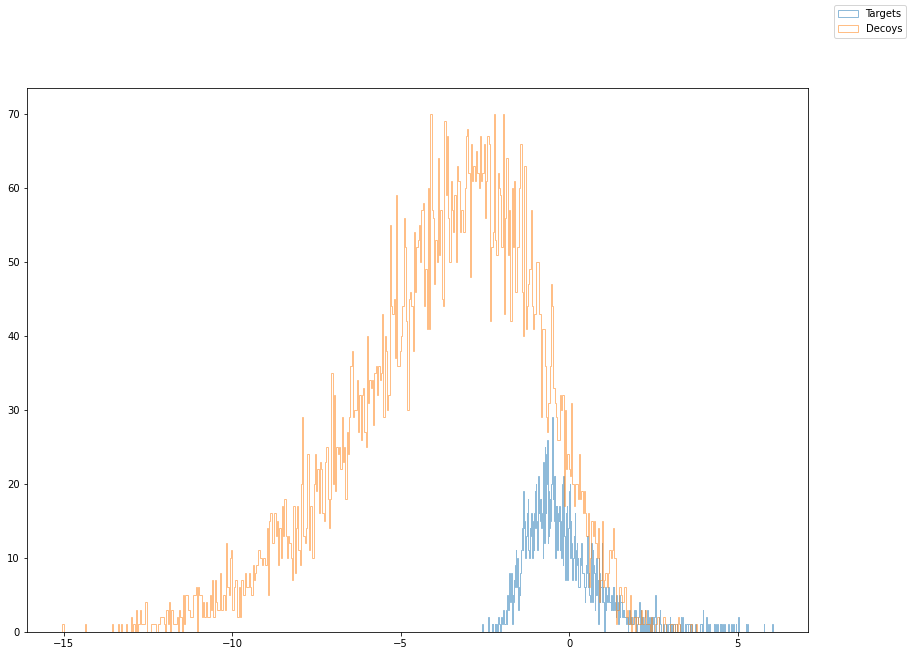

In [89]:
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import figure

test = figure(figsize=(14, 10))

corr_n, corr_bins, _ = pyplot.hist(swath_testing_combined[swath_testing_combined['target']==1]['decision_function'], bins=bins, histtype='step', alpha=0.5, label='Targets')
incorr_n, incorr_bins, _ = pyplot.hist(swath_testing_combined[swath_testing_combined['target']==0]['decision_function'], bins=bins, histtype='step', alpha=0.5, label='Decoys')
# false_n, false_bins, _ = pyplot.hist(swath_combined_rerank[swath_combined_rerank['target']==0]['decision_function'], bins=bins, histtype='step', alpha=0.5, label='False Targets')
# scoring_n, scoring_bins, _ = pyplot.hist(second_ranked_targets['decision_function'], bins=bins, histtype='step', alpha=0.5, label='2nd Ranked Targets')
# false_n, false_bins, _ = pyplot.hist(swath_combined_rerank[swath_combined_rerank['target']==1]['decision_function'], bins=bins, histtype='step', alpha=0.5, label='Labeled Targets')
test.legend(loc='upper right')
#pyplot.axis([-5, 5, 0, 2000])
test.show()
#timestr = time.strftime("%Y%m%d_%H%M%S")
#pyplot.savefig(f'{timestr}_target_decoy_distributions.png')

In [141]:
# from sklearn.metrics import average_precision_score, roc_curve, auc, roc_auc_score

In [142]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay



# precision, recall, thresholds = precision_recall_curve(
#     swath_testing_combined['target'], 
#     swath_testing_combined['decision_function']
# )


# pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [143]:


# fpr, tpr, _ = roc_curve(swath_testing_combined['target'], swath_testing_combined['decision_function'], pos_label=optimized_classifier.classes_[1])

# roc_auc = auc(fpr, tpr)
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()



In [144]:
# import matplotlib.pyplot as plt
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
# plt.show()

In [72]:
from scipy.interpolate import InterpolatedUnivariateSpline, CubicSpline

In [73]:
target_bins = list()
lower_edges = range(0, len(corr_bins)-1)
upper_edges = range(1, len(corr_bins))

for lower_edge, upper_edge in zip(lower_edges, upper_edges):
    target_bins.append(((corr_bins[upper_edge] + corr_bins[lower_edge]) / 2))


null_bins = list()
lower_edges = range(0, len(incorr_bins)-1)
upper_edges = range(1, len(incorr_bins))
for lower_edge, upper_edge in zip(lower_edges, upper_edges):
    null_bins.append(((incorr_bins[upper_edge] + incorr_bins[lower_edge])/2))


target_values = list()
for idx, value in enumerate(corr_n):
    target_values.append(value)


null_values = list()
for idx, value in enumerate(incorr_n):
    null_values.append(value)


In [74]:

import statsmodels.api as sm

target_lowess = sm.nonparametric.lowess(target_values, target_bins, frac=0.04)
target_x = list(zip(*target_lowess))[0]
target_y = list(zip(*target_lowess))[1]

decoy_lowess = sm.nonparametric.lowess(null_values, null_bins, frac=0.04)
decoy_x = list(zip(*decoy_lowess))[0]
decoy_y = list(zip(*decoy_lowess))[1]


target_distribution = InterpolatedUnivariateSpline(target_x, target_y, ext=3, k=1)
null_distribution = InterpolatedUnivariateSpline(decoy_x, decoy_y, ext=3, k=1)

# target_distribution = CubicSpline(target_x, target_y)
# null_distribution = CubicSpline(decoy_x, decoy_y)

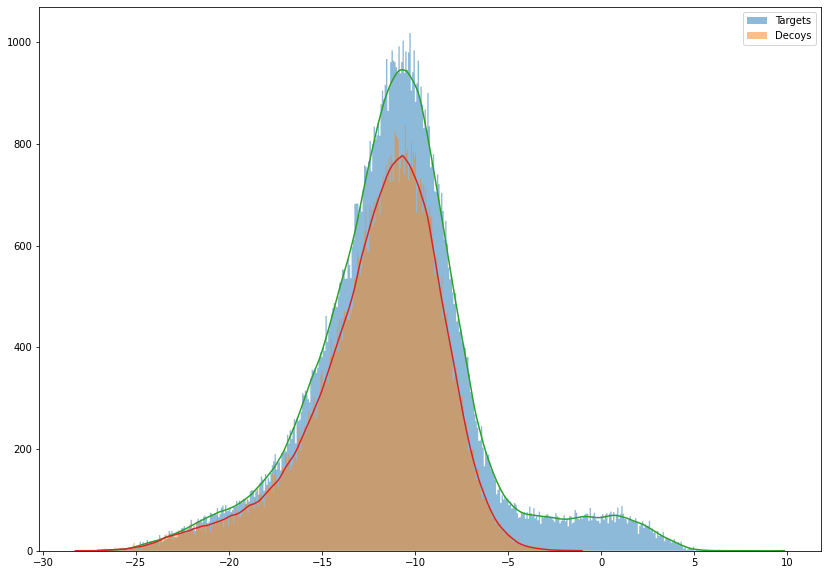

In [75]:
dist_figure = figure(figsize=(14, 10))

corr_n, corr_bins, _ = pyplot.hist(
    swath_combined_rerank[swath_combined_rerank['target']==1]['decision_function'], 
    bins=bins, 
    histtype='stepfilled', 
    alpha=0.5, 
    label='Targets'
)

incorr_n, incorr_bins, _ = pyplot.hist(
    swath_combined_rerank[swath_combined_rerank['target']==0]['decision_function'], 
    bins=bins, 
    histtype='stepfilled', 
    alpha=0.5, 
    label='Decoys'
)

pyplot.plot(target_bins, target_distribution(target_bins), )
pyplot.plot(null_bins, null_distribution(null_bins))
pyplot.legend(loc='upper right')
pyplot.show()


In [76]:
def calc_q_value(prob_score, target_dist, null_dist):
    try:
        null_area = null_dist.integral(a=prob_score, b=decoy_x[-1])
        total_area = null_area + target_dist.integral(a=prob_score, b=target_x[-1])
        return null_area / total_area
    except ZeroDivisionError:
        if prob_score < incorr_bins[0]:
            return 1.0
        elif prob_score > corr_bins[-1]:
            return 0.0

def calc_p_value(prob_score, target_dist, null_dist):
    return null_dist.integral(a=prob_score, b=decoy_x[-1]) / null_dist.integral(a=decoy_x[0], b=decoy_x[-1])
    
def calc_pep_value(prob_score, target_dist, null_dist):
    try:
        return null_dist(prob_score) / (null_dist(prob_score) + target_dist(prob_score))
    except ValueError:
        if prob_score < decoy_x[0]:
            return 1.0
        elif prob_score > target_x[-1]:
            return 0.0

In [77]:
# swath_combined_rerank = swath_combined.loc[
#     swath_combined.groupby(['transition_group_id'])['decision_function'].idxmax()
# ]

In [78]:

swath_combined['q_value'] = swath_combined['decision_function'].apply(
    calc_q_value, 
    target_dist=target_distribution, 
    null_dist=null_distribution
)


In [79]:
swath_combined_rerank = swath_combined.loc[
    swath_combined.groupby(['transition_group_id'])['q_value'].idxmin()
]

In [80]:
cutoff = 0.01

In [81]:
pass_threshold = swath_combined_rerank[(swath_combined_rerank['q_value'] <= cutoff)]
#pass_threshold = pass_threshold[pass_threshold['target'] == 1.0]

In [82]:
pass_threshold.set_index(['transition_group_id'])

feature_id   exp_rt  norm_rt   delta_rt  \
transition_group_id                                                     
9                     467174998841251521  4570.59  69.3896    4.90784   
26                   4028357726591627117  4655.66  72.3090  129.59700   
37                   1909020774051397431  4678.57  73.1002 -105.47500   
52                   4134075369881370294  4276.43  59.3262   -3.82853   
58                   1330247595467533665  4020.62  51.3274  -44.33990   
...                                  ...      ...      ...        ...   
212903               6300848035768337056  4853.89  79.3472  276.39300   
212929                585275523166625677  3213.51  33.8040 -209.38200   
215049               6315015910260948037  4476.62  66.1907   89.58560   
215922               8547183527941889764  4196.61  56.6682   10.59480   
217549               2159690688178789766  4750.67  75.6424  275.83600   

                              mz  charge  decoy      peptide_sequence  \
transition_group_id                                                     
9                     581.821300       2      0            VLTIDPTEFK   
26                    652.366500       2      0           VLTPELYAELR   
37                    782.940300       2      0        VLTQLVATYPQGFK   
52                    825.430300       2      0       VLTTGYWPTQSATPK   
58                    539.771100       2      0             VLTWESGMR   
...                          ...     ...    ...                   ...   
212903               1023.539748       2      1  VMMVALQPAGAINTASIAQK   
212929                429.737619       2      1              VELANANK   
215049                769.393211       2      1      VGVSTMLGAFQSAGGR   
215922                635.853713       2      1          VIEIAGEDVGLR   
217549                575.320462       2      1            VAQLMEFAIK   

                                      modified_peptide_sequence  \
transition_group_id                                               
9                                                    VLTIDPTEFK   
26                                                  VLTPELYAELR   
37                                               VLTQLVATYPQGFK   
52                                              VLTTGYWPTQSATPK   
58                                                    VLTWESGMR   
...                                                         ...   
212903               VM(UniMod:35)M(UniMod:35)VALQPAGAINTASIAQK   
212929                                                 VELANANK   
215049                                         VGVSTMLGAFQSAGGR   
215922                                             VIEIAGEDVGLR   
217549                                               VAQLMEFAIK   

                               protein_accession  ...  var_massdev_score.1  \
transition_group_id                               ...                        
9                           sp|P53621|COPA_HUMAN  ...             2.046213   
26                          sp|P12277|KCRB_HUMAN  ...             0.843786   
37                         sp|P78329|CP4F2_HUMAN  ...             1.835087   
52                          sp|Q13618|CUL3_HUMAN  ...             2.392188   
58                         sp|Q99715|COCA1_HUMAN  ...             2.560707   
...                                          ...  ...                  ...   
212903                DECOY_sp|P18206|VINC_HUMAN  ...             3.043931   
212929               DECOY_sp|Q8N2U9|S66A2_HUMAN  ...             3.323593   
215049                DECOY_sp|Q96N76|HUTU_HUMAN  ...             2.216301   
215922               DECOY_sp|O95861|BPNT1_HUMAN  ...             1.656017   
217549                DECOY_sp|Q99698|LYST_HUMAN  ...             2.087997   

                     var_massdev_score_weighted  var_norm_rt_score  \
transition_group_id                                                  
9                                      1.613004           0.365919   
26                               

In [124]:
swath_data.set_index(['transition_group_id'])

peptide_group_label  \
transition_group_id                                                      
100077_run0                                        DECOY_LSPIFRDFLNR_3   
100077_run0                                        DECOY_LSPIFRDFLNR_3   
100077_run0                                        DECOY_LSPIFRDFLNR_3   
100077_run0                                        DECOY_LSPIFRDFLNR_3   
100077_run0                                        DECOY_LSPIFRDFLNR_3   
...                                                                ...   
99650_run0           DECOY_LSETGGYGTLQHGEDTVPQGPESQAESIPIIVTPAPESIL...   
99650_run0           DECOY_LSETGGYGTLQHGEDTVPQGPESQAESIPIIVTPAPESIL...   
99650_run0           DECOY_LSETGGYGTLQHGEDTVPQGPESQAESIPIIVTPAPESIL...   
99650_run0           DECOY_LSETGGYGTLQHGEDTVPQGPESQAESIPIIVTPAPESIL...   
99650_run0           DECOY_LSETGGYGTLQHGEDTVPQGPESQAESIPIIVTPAPESIL...   

                                                filename           rt  \
transition_group_id                                                     
100077_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  5289.486070   
100077_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  5398.439174   
100077_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  5182.656734   
100077_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  5069.119731   
100077_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  5232.316456   
...                                                  ...          ...   
99650_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  6235.138816   
99650_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  6071.091754   
99650_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  6300.363505   
99650_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  6481.709729   
99650_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  6046.270268   

                                         id  \
transition_group_id                           
100077_run0          f_12024882525403755359   
100077_run0           f_2071071388533442298   
100077_run0           f_8964983824671358905   
100077_run0          f_10313461434612229208   
100077_run0          f_14932312763515434057   
...                                     ...   
99650_run0            f_1585297146556749629   
99650_run0            f_8682440214516089847   
99650_run0           f_10942042263089164171   
99650_run0            f_9041866249659482264   
99650_run0            f_2453932821895096923   

                                                           sequence  mc  \
transition_group_id                                                       
100077_run0                                             LIPDFRNSFLK   1   
100077_run0                                             LIPDFRNSFLK   1   
100077_run0                                             LIPDFRNSFLK   1   
100077_run0                                             LIPDFRNSFLK   1   
100077_run0                                             LIPDFRNSFLK   1   
...                                                             ...  ..   
99650_run0           LDSIDQTEALTQSIIHEPSTPSTGLEQGPVYGGPEPLGAQSEVIHK   0   
99650_run0           LDSIDQTEALTQSIIHEPSTPSTGLEQGPVYGGPEPLGAQSEVIHK   0   
99650_run0           LDSIDQTEALTQSIIHEPSTPSTGLEQGPVYGGPEPLGAQSEVIHK   0   
99650_run0           LDSIDQTEALTQSIIHEPSTPSTGLEQGPVYGGPEPLGAQSEVIHK   0   
99650_run0           LDSIDQTEALTQSIIHEPSTPSTGLEQGPVYGGPEPLGAQSEVIHK   0   

                                                    fullpeptidename  charge  \
transition_group_id                                                           
100077_run0                                             LIPDFRNSFLK       3   
100077_run0                                             LIPDFRNSFLK       3   
100077_run0                                             LIPDFRNSFLK       3   
100077_run0                                             LIPDFRNSFLK       3   
100077_run0                                             LIPDFRNSFLK       3 

In [125]:
swath_combined_rerank.set_index(['transition_group_id'])

peptide_group_label  \
transition_group_id                                     
0_run0                                              0   
100000_run0                      DECOY_LSMYGVDLHHAK_3   
100001_run0                        DECOY_LSMYGVDLHK_2   
100002_run0                        DECOY_LSMYGVDLHK_3   
100003_run0                       DECOY_LSNAQVIDVTK_2   
...                                               ...   
99998_run0                       DECOY_LSMTNDPLEAAR_2   
99999_run0                      DECOY_LSMWDRPDDLIGR_3   
9999_run0                               ALLAAFDFPFR_2   
999_run0                      .(Acetyl)ATSWGSILQDEK_1   
9_run0               .(Acetyl)AAAAAAGPEMVRGQVFDVGPR_3   

                                                filename           rt  \
transition_group_id                                                     
0_run0               mzml/E1808/Kidney/TM_M1810_152.mzML  4754.115380   
100000_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  2893.695269   
100001_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  3374.745859   
100002_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  3577.077948   
100003_run0          mzml/E1808/Kidney/TM_M1810_152.mzML  3246.373819   
...                                                  ...          ...   
99998_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  3967.487805   
99999_run0           mzml/E1808/Kidney/TM_M1810_152.mzML  4990.911114   
9999_run0            mzml/E1808/Kidney/TM_M1810_152.mzML  7525.331932   
999_run0             mzml/E1808/Kidney/TM_M1810_152.mzML  6461.791253   
9_run0               mzml/E1808/Kidney/TM_M1810_152.mzML  5434.982040   

                                         id               sequence  mc  \
transition_group_id                                                      
0_run0                 f_481694340755003681       AAAAAAAAAAGAAGGR   0   
100000_run0          f_10897010725097756499           LMGVLSYDAHHR   0   
100001_run0           f_2258902804641075777             LMGVLSYDHR   0   
100002_run0           f_7529244482859883027             LMGVLSYDHR   0   
100003_run0          f_13911927909466173952            LNQVDSAIVTR   0   
...                                     ...                    ...  ..   
99998_run0           f_10821636659602318121           LMNDESPTLAAK   0   
99999_run0           f_18115163082821940036          LMDDLRPSWDIGK   0   
9999_run0             f_1960332091291681718            ALLAAFDFPFR   0   
999_run0             f_15466444013143755190           ATSWGSILQDEK   0   
9_run0               f_17439452507878793499  AAAAAAGPEMVRGQVFDVGPR   1   

                                     fullpeptidename  charge          m/z  \
transition_group_id                                                         
0_run0                    (UniMod:1)AAAAAAAAAAGAAGGR       2   620.823300   
100000_run0                             LMGVLSYDAHHR       3   466.903080   
100001_run0                               LMGVLSYDHR       2   595.802968   
100002_run0                               LMGVLSYDHR       3   397.537738   
100003_run0                              LNQVDSAIVTR       2   608.338230   
...                                              ...     ...          ...   
99998_run0                              LMNDESPTLAAK       2   645.323931   
99999_run0                             LMDDLRPSWDIGK       3   515.929184   
9999_run0                                ALLAAFDFPFR       2   634.345300   
999_run0                      (UniMod:1)ATSWGSILQDEK       1  1376.669200   
9_run0               (UniMod:1)AAAAAAGPEMVRGQVFDVGPR       3   704.693300   

                        intensity  ... var_xcorr_coelution  \
transition_group_id                ...                       
0_run0               1.355423e+06  ...            0.761310   
100000_run0          2.406465e+05  ...            0.439933   
100001_run0          3.936870e+04  ...           -0.432929   
100002_run0          7.134049e+04  ...            0.982546   
10000

In [83]:
print(len(pass_threshold[pass_threshold['target'] == 1]), len(pass_threshold[pass_threshold['target'] == 0]))

6154 80


In [84]:
len(pass_threshold[pass_threshold['target'] == 0]) / len(pass_threshold[pass_threshold['target'] == 1])

0.012999675008124796

In [128]:
targets = swath_data.loc[
    pass_threshold.index
]

In [129]:
decoys = swath_data.loc[
    swath_combined_rerank[(swath_combined_rerank['target'] == 0.0)].index
]

In [130]:
removed_noise = pandas.concat([targets, decoys])

In [86]:
pass_threshold.columns

Index(['transition_group_id', 'feature_id', 'exp_rt', 'norm_rt', 'delta_rt',
       'mz', 'charge', 'decoy', 'peptide_sequence',
       'modified_peptide_sequence', 'protein_accession', 'protein_decoy',
       'area_intensity', 'apex_intensity', 'ms2_area_intensity',
       'total_area_intensity', 'd_score', 'target', 'var_massdev_score',
       'var_isotope_correlation_score', 'var_isotope_overlap_score',
       'var_xcorr_coelution_contrast', 'var_xcorr_coelution_combined',
       'var_xcorr_shape_contrast', 'var_xcorr_shape_combined',
       'var_bseries_score', 'var_dotprod_score', 'var_intensity_score',
       'var_isotope_correlation_score.1', 'var_isotope_overlap_score.1',
       'var_library_corr', 'var_library_dotprod', 'var_library_manhattan',
       'var_library_rmsd', 'var_library_rootmeansquare', 'var_library_sangle',
       'var_log_sn_score', 'var_manhattan_score', 'var_massdev_score.1',
       'var_massdev_score_weighted', 'var_norm_rt_score',
       'var_xcorr_coelutio

In [87]:
len(pass_threshold.groupby(['protein_accession']))

2219

In [85]:
len(pass_threshold.groupby(['peptide_group_label']))

48265

In [ ]:
protein_groups = pass_threshold[pass_threshold['decoy'] == 0.0].groupby(['proteinname'])

In [ ]:
pg_df = [group for _, group in protein_groups]

In [ ]:
protein_groups = list()
for group in pg_df:
    if len(group) >= 2:
        protein_groups.append(group)